In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

In [ ]:
class LaticiferDataset(Dataset):
    def __init__(self, df, root_dir, image_size=(512, 512), augment=False):
        self.df = df
        self.root = root_dir
        self.augment = augment
        self.image_size = image_size

        self.transforms = A.Compose([
            A.Resize(*image_size),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.ElasticTransform(p=0.3),
            A.GaussianBlur(p=0.2),
            A.Normalize(),
            ToTensorV2()
        ]) if augment else A.Compose([
            A.Resize(*image_size),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        gray_path = os.path.join(self.root, row['gray_image_path'])
        enhanced_path = os.path.join(self.root, row['enhanced_image_path'])
        mask_path = os.path.join(self.root, "masks", os.path.basename(row['gray_image_path']).replace(".tif", "_mask.tif"))

        image = np.array(Image.open(enhanced_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L")) // 255

        augmented = self.transforms(image=image, mask=mask)
        return augmented['image'], augmented['mask'].unsqueeze(0).float()

In [3]:
# U-Net Model (Lightweight)
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.final(d1))

In [4]:
# Dice Loss
def dice_loss(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

In [5]:
def compute_dice(preds, targets, threshold=0.5, eps=1e-7):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean().item()

In [ ]:

def train_model(model, train_loader, test_loader, num_epochs=20, save_dir=None):
    model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = lambda pred, target: nn.BCELoss()(pred, target) + dice_loss(pred, target)

    best_dice = 0.0
    best_model_path = None

    for epoch in range(1, num_epochs + 1):
        # --- Training ---
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
            images, masks = images.cuda(), masks.cuda()
            preds = model(images)

            loss = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"🔁 Epoch {epoch}: Train Loss = {avg_train_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_loss = 0
        dice_scores = []

        with torch.no_grad():
            for images, masks in tqdm(test_loader, desc=f"Epoch {epoch} - Validation"):
                images, masks = images.cuda(), masks.cuda()
                preds = model(images)

                loss = criterion(preds, masks)
                val_loss += loss.item()

                dice = compute_dice(preds, masks)
                dice_scores.append(dice)

        avg_val_loss = val_loss / len(test_loader)
        avg_dice = np.mean(dice_scores)
        print(f"✅ Epoch {epoch}: Val Loss = {avg_val_loss:.4f} | Dice = {avg_dice:.4f}")

        # --- Save best model ---
        if avg_dice > best_dice:
            best_dice = avg_dice
            if save_dir:
                os.makedirs(save_dir, exist_ok=True)
                best_model_path = os.path.join(save_dir, f"best_unet_dice{best_dice:.4f}.pth")
                torch.save(model.state_dict(), best_model_path)
                print(f"New best model saved with Dice {best_dice:.4f} at {best_model_path}")

    print("Best Dice achieved:", best_dice)
    if best_model_path:
        print("Best model path:", best_model_path)


In [7]:
dataset_root = "/home/sergio/datasets/laticifers"
df = pd.read_csv(os.path.join(dataset_root, "laticifer_dataset_index.csv"))
df = df[df["is_labeled"] == True].reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_dataset = LaticiferDataset(train_df, dataset_root, augment=True)
test_dataset = LaticiferDataset(val_df, dataset_root, augment=False)

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

Total samples: 34
Training samples: 30
Test samples: 4


In [8]:
model = UNet(in_channels=1).cuda()

train_model(
    model=model, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    num_epochs=200,
    save_dir=dataset_root
)

Epoch 1 - Training: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


🔁 Epoch 1: Train Loss = 1.5460


Epoch 1 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


✅ Epoch 1: Val Loss = 1.4805 | Dice = 0.0000
New best model saved with Dice 0.0000 at /home/sergio/datasets/laticifers/best_unet_dice0.0000.pth


Epoch 2 - Training: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


🔁 Epoch 2: Train Loss = 1.2867


Epoch 2 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


✅ Epoch 2: Val Loss = 1.1840 | Dice = 0.0000


Epoch 3 - Training: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


🔁 Epoch 3: Train Loss = 1.1660


Epoch 3 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


✅ Epoch 3: Val Loss = 1.1427 | Dice = 0.0000


Epoch 4 - Training: 100%|██████████| 15/15 [00:18<00:00,  1.26s/it]


🔁 Epoch 4: Train Loss = 1.1422


Epoch 4 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


✅ Epoch 4: Val Loss = 1.1272 | Dice = 0.0000


Epoch 5 - Training: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


🔁 Epoch 5: Train Loss = 1.1432


Epoch 5 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


✅ Epoch 5: Val Loss = 1.1163 | Dice = 0.0000


Epoch 6 - Training: 100%|██████████| 15/15 [00:18<00:00,  1.26s/it]


🔁 Epoch 6: Train Loss = 1.1278


Epoch 6 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


✅ Epoch 6: Val Loss = 1.1107 | Dice = 0.0000


Epoch 7 - Training: 100%|██████████| 15/15 [00:18<00:00,  1.26s/it]


🔁 Epoch 7: Train Loss = 1.1202


Epoch 7 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


✅ Epoch 7: Val Loss = 1.0902 | Dice = 0.0000


Epoch 8 - Training: 100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


🔁 Epoch 8: Train Loss = 1.1051


Epoch 8 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


✅ Epoch 8: Val Loss = 1.0769 | Dice = 0.0000


Epoch 9 - Training: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


🔁 Epoch 9: Train Loss = 1.0860


Epoch 9 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


✅ Epoch 9: Val Loss = 1.0612 | Dice = 0.0000


Epoch 10 - Training: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


🔁 Epoch 10: Train Loss = 1.0562


Epoch 10 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


✅ Epoch 10: Val Loss = 1.0209 | Dice = 0.0000


Epoch 11 - Training: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


🔁 Epoch 11: Train Loss = 1.0750


Epoch 11 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


✅ Epoch 11: Val Loss = 1.0463 | Dice = 0.0000


Epoch 12 - Training: 100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


🔁 Epoch 12: Train Loss = 1.0719


Epoch 12 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


✅ Epoch 12: Val Loss = 1.0325 | Dice = 0.0000


Epoch 13 - Training: 100%|██████████| 15/15 [00:19<00:00,  1.32s/it]


🔁 Epoch 13: Train Loss = 1.0451


Epoch 13 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


✅ Epoch 13: Val Loss = 1.0144 | Dice = 0.0000


Epoch 14 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 14: Train Loss = 1.0359


Epoch 14 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 14: Val Loss = 1.0019 | Dice = 0.0005
New best model saved with Dice 0.0005 at /home/sergio/datasets/laticifers/best_unet_dice0.0005.pth


Epoch 15 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 15: Train Loss = 1.0124


Epoch 15 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


✅ Epoch 15: Val Loss = 0.9831 | Dice = 0.0752
New best model saved with Dice 0.0752 at /home/sergio/datasets/laticifers/best_unet_dice0.0752.pth


Epoch 16 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 16: Train Loss = 0.9999


Epoch 16 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


✅ Epoch 16: Val Loss = 0.9772 | Dice = 0.1654
New best model saved with Dice 0.1654 at /home/sergio/datasets/laticifers/best_unet_dice0.1654.pth


Epoch 17 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 17: Train Loss = 1.0071


Epoch 17 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 17: Val Loss = 0.9661 | Dice = 0.2370
New best model saved with Dice 0.2370 at /home/sergio/datasets/laticifers/best_unet_dice0.2370.pth


Epoch 18 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 18: Train Loss = 1.0089


Epoch 18 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


✅ Epoch 18: Val Loss = 0.9715 | Dice = 0.2127


Epoch 19 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 19: Train Loss = 0.9953


Epoch 19 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 19: Val Loss = 0.9693 | Dice = 0.2280


Epoch 20 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 20: Train Loss = 0.9779


Epoch 20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


✅ Epoch 20: Val Loss = 0.9698 | Dice = 0.2627
New best model saved with Dice 0.2627 at /home/sergio/datasets/laticifers/best_unet_dice0.2627.pth


Epoch 21 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 21: Train Loss = 0.9751


Epoch 21 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


✅ Epoch 21: Val Loss = 0.9642 | Dice = 0.2597


Epoch 22 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


🔁 Epoch 22: Train Loss = 0.9672


Epoch 22 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


✅ Epoch 22: Val Loss = 0.9643 | Dice = 0.2423


Epoch 23 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 23: Train Loss = 0.9689


Epoch 23 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 23: Val Loss = 0.9607 | Dice = 0.2546


Epoch 24 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 24: Train Loss = 0.9916


Epoch 24 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 24: Val Loss = 0.9858 | Dice = 0.2822
New best model saved with Dice 0.2822 at /home/sergio/datasets/laticifers/best_unet_dice0.2822.pth


Epoch 25 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 25: Train Loss = 0.9844


Epoch 25 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


✅ Epoch 25: Val Loss = 0.9655 | Dice = 0.2474


Epoch 26 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 26: Train Loss = 0.9668


Epoch 26 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


✅ Epoch 26: Val Loss = 0.9538 | Dice = 0.2703


Epoch 27 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


🔁 Epoch 27: Train Loss = 0.9938


Epoch 27 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 27: Val Loss = 0.9619 | Dice = 0.2463


Epoch 28 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 28: Train Loss = 0.9803


Epoch 28 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 28: Val Loss = 0.9801 | Dice = 0.2691


Epoch 29 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 29: Train Loss = 0.9675


Epoch 29 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


✅ Epoch 29: Val Loss = 0.9667 | Dice = 0.2715


Epoch 30 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 30: Train Loss = 0.9518


Epoch 30 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 30: Val Loss = 0.9489 | Dice = 0.2696


Epoch 31 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 31: Train Loss = 0.9639


Epoch 31 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


✅ Epoch 31: Val Loss = 0.9536 | Dice = 0.2593


Epoch 32 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 32: Train Loss = 0.9580


Epoch 32 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


✅ Epoch 32: Val Loss = 0.9492 | Dice = 0.2916
New best model saved with Dice 0.2916 at /home/sergio/datasets/laticifers/best_unet_dice0.2916.pth


Epoch 33 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 33: Train Loss = 0.9494


Epoch 33 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 33: Val Loss = 0.9531 | Dice = 0.2998
New best model saved with Dice 0.2998 at /home/sergio/datasets/laticifers/best_unet_dice0.2998.pth


Epoch 34 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 34: Train Loss = 0.9431


Epoch 34 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


✅ Epoch 34: Val Loss = 0.9413 | Dice = 0.2981


Epoch 35 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 35: Train Loss = 0.9493


Epoch 35 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


✅ Epoch 35: Val Loss = 0.9498 | Dice = 0.2681


Epoch 36 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 36: Train Loss = 0.9355


Epoch 36 - Validation: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


✅ Epoch 36: Val Loss = 0.9512 | Dice = 0.2971


Epoch 37 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 37: Train Loss = 0.9410


Epoch 37 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


✅ Epoch 37: Val Loss = 0.9277 | Dice = 0.3067
New best model saved with Dice 0.3067 at /home/sergio/datasets/laticifers/best_unet_dice0.3067.pth


Epoch 38 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 38: Train Loss = 0.9364


Epoch 38 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 38: Val Loss = 0.9253 | Dice = 0.2791


Epoch 39 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 39: Train Loss = 0.9379


Epoch 39 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 39: Val Loss = 0.9251 | Dice = 0.3082
New best model saved with Dice 0.3082 at /home/sergio/datasets/laticifers/best_unet_dice0.3082.pth


Epoch 40 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


🔁 Epoch 40: Train Loss = 0.9349


Epoch 40 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 40: Val Loss = 0.9237 | Dice = 0.2823


Epoch 41 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 41: Train Loss = 0.9363


Epoch 41 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 41: Val Loss = 0.9246 | Dice = 0.3210
New best model saved with Dice 0.3210 at /home/sergio/datasets/laticifers/best_unet_dice0.3210.pth


Epoch 42 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 42: Train Loss = 0.9343


Epoch 42 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 42: Val Loss = 0.9378 | Dice = 0.2492


Epoch 43 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 43: Train Loss = 0.9266


Epoch 43 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


✅ Epoch 43: Val Loss = 0.9254 | Dice = 0.2765


Epoch 44 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


🔁 Epoch 44: Train Loss = 0.9294


Epoch 44 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


✅ Epoch 44: Val Loss = 0.9199 | Dice = 0.3072


Epoch 45 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


🔁 Epoch 45: Train Loss = 0.9171


Epoch 45 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 45: Val Loss = 0.9116 | Dice = 0.2968


Epoch 46 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


🔁 Epoch 46: Train Loss = 0.9210


Epoch 46 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


✅ Epoch 46: Val Loss = 0.9127 | Dice = 0.2922


Epoch 47 - Training: 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


🔁 Epoch 47: Train Loss = 0.9085


Epoch 47 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


✅ Epoch 47: Val Loss = 0.8938 | Dice = 0.3182


Epoch 48 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 48: Train Loss = 0.9107


Epoch 48 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


✅ Epoch 48: Val Loss = 0.9080 | Dice = 0.3058


Epoch 49 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 49: Train Loss = 0.9067


Epoch 49 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 49: Val Loss = 0.9027 | Dice = 0.2919


Epoch 50 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 50: Train Loss = 0.9041


Epoch 50 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 50: Val Loss = 0.8931 | Dice = 0.3082


Epoch 51 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 51: Train Loss = 0.9337


Epoch 51 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 51: Val Loss = 0.9178 | Dice = 0.2952


Epoch 52 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 52: Train Loss = 0.9246


Epoch 52 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 52: Val Loss = 0.9243 | Dice = 0.3020


Epoch 53 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 53: Train Loss = 0.9202


Epoch 53 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 53: Val Loss = 0.9137 | Dice = 0.2786


Epoch 54 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 54: Train Loss = 0.9113


Epoch 54 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 54: Val Loss = 0.9008 | Dice = 0.3072


Epoch 55 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 55: Train Loss = 0.9055


Epoch 55 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 55: Val Loss = 0.9041 | Dice = 0.3096


Epoch 56 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 56: Train Loss = 0.8981


Epoch 56 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 56: Val Loss = 0.9108 | Dice = 0.2969


Epoch 57 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 57: Train Loss = 0.9055


Epoch 57 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 57: Val Loss = 0.8999 | Dice = 0.3225
New best model saved with Dice 0.3225 at /home/sergio/datasets/laticifers/best_unet_dice0.3225.pth


Epoch 58 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 58: Train Loss = 0.9078


Epoch 58 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 58: Val Loss = 0.9110 | Dice = 0.2920


Epoch 59 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 59: Train Loss = 0.9010


Epoch 59 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 59: Val Loss = 0.8988 | Dice = 0.3198


Epoch 60 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 60: Train Loss = 0.9010


Epoch 60 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


✅ Epoch 60: Val Loss = 0.8928 | Dice = 0.3176


Epoch 61 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 61: Train Loss = 0.8888


Epoch 61 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 61: Val Loss = 0.8792 | Dice = 0.3347
New best model saved with Dice 0.3347 at /home/sergio/datasets/laticifers/best_unet_dice0.3347.pth


Epoch 62 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 62: Train Loss = 0.8854


Epoch 62 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


✅ Epoch 62: Val Loss = 0.8872 | Dice = 0.3111


Epoch 63 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 63: Train Loss = 0.8941


Epoch 63 - Validation: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


✅ Epoch 63: Val Loss = 0.8806 | Dice = 0.3404
New best model saved with Dice 0.3404 at /home/sergio/datasets/laticifers/best_unet_dice0.3404.pth


Epoch 64 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 64: Train Loss = 0.8895


Epoch 64 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


✅ Epoch 64: Val Loss = 0.8826 | Dice = 0.3184


Epoch 65 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 65: Train Loss = 0.8989


Epoch 65 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 65: Val Loss = 0.8969 | Dice = 0.3344


Epoch 66 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 66: Train Loss = 0.8892


Epoch 66 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


✅ Epoch 66: Val Loss = 0.8805 | Dice = 0.3229


Epoch 67 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 67: Train Loss = 0.8900


Epoch 67 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 67: Val Loss = 0.8823 | Dice = 0.3344


Epoch 68 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 68: Train Loss = 0.8827


Epoch 68 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 68: Val Loss = 0.8735 | Dice = 0.3380


Epoch 69 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 69: Train Loss = 0.8819


Epoch 69 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


✅ Epoch 69: Val Loss = 0.8665 | Dice = 0.3479
New best model saved with Dice 0.3479 at /home/sergio/datasets/laticifers/best_unet_dice0.3479.pth


Epoch 70 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 70: Train Loss = 0.9019


Epoch 70 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


✅ Epoch 70: Val Loss = 0.8809 | Dice = 0.3349


Epoch 71 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 71: Train Loss = 0.8893


Epoch 71 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


✅ Epoch 71: Val Loss = 0.8813 | Dice = 0.3369


Epoch 72 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 72: Train Loss = 0.8744


Epoch 72 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


✅ Epoch 72: Val Loss = 0.8806 | Dice = 0.3326


Epoch 73 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 73: Train Loss = 0.8673


Epoch 73 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 73: Val Loss = 0.8691 | Dice = 0.3471


Epoch 74 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 74: Train Loss = 0.8691


Epoch 74 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 74: Val Loss = 0.8578 | Dice = 0.3578
New best model saved with Dice 0.3578 at /home/sergio/datasets/laticifers/best_unet_dice0.3578.pth


Epoch 75 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 75: Train Loss = 0.8740


Epoch 75 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 75: Val Loss = 0.8776 | Dice = 0.3259


Epoch 76 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 76: Train Loss = 0.8685


Epoch 76 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


✅ Epoch 76: Val Loss = 0.8685 | Dice = 0.3368


Epoch 77 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 77: Train Loss = 0.8716


Epoch 77 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 77: Val Loss = 0.8671 | Dice = 0.3550


Epoch 78 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


🔁 Epoch 78: Train Loss = 0.8641


Epoch 78 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 78: Val Loss = 0.8680 | Dice = 0.3417


Epoch 79 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 79: Train Loss = 0.8704


Epoch 79 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 79: Val Loss = 0.8635 | Dice = 0.3575


Epoch 80 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 80: Train Loss = 0.8693


Epoch 80 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 80: Val Loss = 0.8578 | Dice = 0.3530


Epoch 81 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 81: Train Loss = 0.8524


Epoch 81 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 81: Val Loss = 0.8570 | Dice = 0.3575


Epoch 82 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 82: Train Loss = 0.8592


Epoch 82 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


✅ Epoch 82: Val Loss = 0.8485 | Dice = 0.3647
New best model saved with Dice 0.3647 at /home/sergio/datasets/laticifers/best_unet_dice0.3647.pth


Epoch 83 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


🔁 Epoch 83: Train Loss = 0.8618


Epoch 83 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 83: Val Loss = 0.8537 | Dice = 0.3488


Epoch 84 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 84: Train Loss = 0.8509


Epoch 84 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


✅ Epoch 84: Val Loss = 0.8458 | Dice = 0.3530


Epoch 85 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 85: Train Loss = 0.8382


Epoch 85 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 85: Val Loss = 0.8400 | Dice = 0.3665
New best model saved with Dice 0.3665 at /home/sergio/datasets/laticifers/best_unet_dice0.3665.pth


Epoch 86 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 86: Train Loss = 0.8489


Epoch 86 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


✅ Epoch 86: Val Loss = 0.8655 | Dice = 0.3406


Epoch 87 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 87: Train Loss = 0.8498


Epoch 87 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


✅ Epoch 87: Val Loss = 0.8363 | Dice = 0.3738
New best model saved with Dice 0.3738 at /home/sergio/datasets/laticifers/best_unet_dice0.3738.pth


Epoch 88 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 88: Train Loss = 0.8353


Epoch 88 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 88: Val Loss = 0.8605 | Dice = 0.3344


Epoch 89 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 89: Train Loss = 0.8520


Epoch 89 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 89: Val Loss = 0.8473 | Dice = 0.3691


Epoch 90 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 90: Train Loss = 0.8408


Epoch 90 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 90: Val Loss = 0.8294 | Dice = 0.3804
New best model saved with Dice 0.3804 at /home/sergio/datasets/laticifers/best_unet_dice0.3804.pth


Epoch 91 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 91: Train Loss = 0.8354


Epoch 91 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 91: Val Loss = 0.8466 | Dice = 0.3660


Epoch 92 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 92: Train Loss = 0.8357


Epoch 92 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 92: Val Loss = 0.8435 | Dice = 0.3562


Epoch 93 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 93: Train Loss = 0.8528


Epoch 93 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


✅ Epoch 93: Val Loss = 0.8311 | Dice = 0.3802


Epoch 94 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 94: Train Loss = 0.8399


Epoch 94 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 94: Val Loss = 0.8304 | Dice = 0.3712


Epoch 95 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 95: Train Loss = 0.8360


Epoch 95 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 95: Val Loss = 0.8481 | Dice = 0.3618


Epoch 96 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 96: Train Loss = 0.8318


Epoch 96 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 96: Val Loss = 0.8428 | Dice = 0.3580


Epoch 97 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 97: Train Loss = 0.8232


Epoch 97 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 97: Val Loss = 0.8313 | Dice = 0.3775


Epoch 98 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 98: Train Loss = 0.8199


Epoch 98 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 98: Val Loss = 0.8261 | Dice = 0.3698


Epoch 99 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 99: Train Loss = 0.8306


Epoch 99 - Validation: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


✅ Epoch 99: Val Loss = 0.8295 | Dice = 0.3693


Epoch 100 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 100: Train Loss = 0.8352


Epoch 100 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 100: Val Loss = 0.8234 | Dice = 0.3778


Epoch 101 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 101: Train Loss = 0.8115


Epoch 101 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


✅ Epoch 101: Val Loss = 0.8294 | Dice = 0.3695


Epoch 102 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 102: Train Loss = 0.8343


Epoch 102 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


✅ Epoch 102: Val Loss = 0.8166 | Dice = 0.3910
New best model saved with Dice 0.3910 at /home/sergio/datasets/laticifers/best_unet_dice0.3910.pth


Epoch 103 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 103: Train Loss = 0.8358


Epoch 103 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 103: Val Loss = 0.8189 | Dice = 0.3864


Epoch 104 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


🔁 Epoch 104: Train Loss = 0.8137


Epoch 104 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


✅ Epoch 104: Val Loss = 0.8227 | Dice = 0.3742


Epoch 105 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 105: Train Loss = 0.8250


Epoch 105 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 105: Val Loss = 0.8129 | Dice = 0.3914
New best model saved with Dice 0.3914 at /home/sergio/datasets/laticifers/best_unet_dice0.3914.pth


Epoch 106 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 106: Train Loss = 0.8179


Epoch 106 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 106: Val Loss = 0.8363 | Dice = 0.3685


Epoch 107 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 107: Train Loss = 0.8112


Epoch 107 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 107: Val Loss = 0.8174 | Dice = 0.3834


Epoch 108 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


🔁 Epoch 108: Train Loss = 0.8374


Epoch 108 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 108: Val Loss = 0.8372 | Dice = 0.3707


Epoch 109 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 109: Train Loss = 0.8157


Epoch 109 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 109: Val Loss = 0.8188 | Dice = 0.3928
New best model saved with Dice 0.3928 at /home/sergio/datasets/laticifers/best_unet_dice0.3928.pth


Epoch 110 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 110: Train Loss = 0.8022


Epoch 110 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 110: Val Loss = 0.8426 | Dice = 0.3614


Epoch 111 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 111: Train Loss = 0.8109


Epoch 111 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 111: Val Loss = 0.8133 | Dice = 0.3855


Epoch 112 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


🔁 Epoch 112: Train Loss = 0.8093


Epoch 112 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 112: Val Loss = 0.8076 | Dice = 0.3941
New best model saved with Dice 0.3941 at /home/sergio/datasets/laticifers/best_unet_dice0.3941.pth


Epoch 113 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 113: Train Loss = 0.8033


Epoch 113 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


✅ Epoch 113: Val Loss = 0.8328 | Dice = 0.3765


Epoch 114 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 114: Train Loss = 0.8098


Epoch 114 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 114: Val Loss = 0.8133 | Dice = 0.3911


Epoch 115 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 115: Train Loss = 0.8014


Epoch 115 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 115: Val Loss = 0.8109 | Dice = 0.3934


Epoch 116 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 116: Train Loss = 0.8015


Epoch 116 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 116: Val Loss = 0.7954 | Dice = 0.4070
New best model saved with Dice 0.4070 at /home/sergio/datasets/laticifers/best_unet_dice0.4070.pth


Epoch 117 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 117: Train Loss = 0.8061


Epoch 117 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 117: Val Loss = 0.8243 | Dice = 0.3720


Epoch 118 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 118: Train Loss = 0.7954


Epoch 118 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


✅ Epoch 118: Val Loss = 0.8139 | Dice = 0.3877


Epoch 119 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 119: Train Loss = 0.7933


Epoch 119 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


✅ Epoch 119: Val Loss = 0.8381 | Dice = 0.3657


Epoch 120 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 120: Train Loss = 0.7961


Epoch 120 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 120: Val Loss = 0.8037 | Dice = 0.3931


Epoch 121 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 121: Train Loss = 0.8059


Epoch 121 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 121: Val Loss = 0.7997 | Dice = 0.4115
New best model saved with Dice 0.4115 at /home/sergio/datasets/laticifers/best_unet_dice0.4115.pth


Epoch 122 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 122: Train Loss = 0.8028


Epoch 122 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


✅ Epoch 122: Val Loss = 0.8151 | Dice = 0.3874


Epoch 123 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 123: Train Loss = 0.7962


Epoch 123 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


✅ Epoch 123: Val Loss = 0.8060 | Dice = 0.3924


Epoch 124 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


🔁 Epoch 124: Train Loss = 0.7890


Epoch 124 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


✅ Epoch 124: Val Loss = 0.8149 | Dice = 0.3893


Epoch 125 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 125: Train Loss = 0.7917


Epoch 125 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


✅ Epoch 125: Val Loss = 0.8006 | Dice = 0.4020


Epoch 126 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 126: Train Loss = 0.7913


Epoch 126 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 126: Val Loss = 0.8047 | Dice = 0.3935


Epoch 127 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 127: Train Loss = 0.7922


Epoch 127 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 127: Val Loss = 0.8181 | Dice = 0.3856


Epoch 128 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 128: Train Loss = 0.7806


Epoch 128 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 128: Val Loss = 0.8020 | Dice = 0.4034


Epoch 129 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 129: Train Loss = 0.7803


Epoch 129 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


✅ Epoch 129: Val Loss = 0.7968 | Dice = 0.4015


Epoch 130 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 130: Train Loss = 0.7831


Epoch 130 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


✅ Epoch 130: Val Loss = 0.8174 | Dice = 0.3844


Epoch 131 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 131: Train Loss = 0.7830


Epoch 131 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 131: Val Loss = 0.8000 | Dice = 0.4092


Epoch 132 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 132: Train Loss = 0.7844


Epoch 132 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


✅ Epoch 132: Val Loss = 0.8075 | Dice = 0.3992


Epoch 133 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 133: Train Loss = 0.7854


Epoch 133 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 133: Val Loss = 0.7852 | Dice = 0.4125
New best model saved with Dice 0.4125 at /home/sergio/datasets/laticifers/best_unet_dice0.4125.pth


Epoch 134 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 134: Train Loss = 0.7757


Epoch 134 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


✅ Epoch 134: Val Loss = 0.7965 | Dice = 0.4073


Epoch 135 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 135: Train Loss = 0.7782


Epoch 135 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


✅ Epoch 135: Val Loss = 0.8026 | Dice = 0.3948


Epoch 136 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 136: Train Loss = 0.7737


Epoch 136 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


✅ Epoch 136: Val Loss = 0.8106 | Dice = 0.4014


Epoch 137 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 137: Train Loss = 0.7793


Epoch 137 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 137: Val Loss = 0.7928 | Dice = 0.4103


Epoch 138 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 138: Train Loss = 0.7827


Epoch 138 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


✅ Epoch 138: Val Loss = 0.8183 | Dice = 0.3899


Epoch 139 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 139: Train Loss = 0.7734


Epoch 139 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


✅ Epoch 139: Val Loss = 0.8152 | Dice = 0.3912


Epoch 140 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


🔁 Epoch 140: Train Loss = 0.7702


Epoch 140 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


✅ Epoch 140: Val Loss = 0.7980 | Dice = 0.4057


Epoch 141 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 141: Train Loss = 0.7719


Epoch 141 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 141: Val Loss = 0.8229 | Dice = 0.3752


Epoch 142 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 142: Train Loss = 0.7640


Epoch 142 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 142: Val Loss = 0.8207 | Dice = 0.3856


Epoch 143 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 143: Train Loss = 0.7706


Epoch 143 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 143: Val Loss = 0.8032 | Dice = 0.4032


Epoch 144 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 144: Train Loss = 0.7621


Epoch 144 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


✅ Epoch 144: Val Loss = 0.7914 | Dice = 0.4091


Epoch 145 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


🔁 Epoch 145: Train Loss = 0.7611


Epoch 145 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


✅ Epoch 145: Val Loss = 0.7975 | Dice = 0.4028


Epoch 146 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 146: Train Loss = 0.7553


Epoch 146 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 146: Val Loss = 0.8427 | Dice = 0.3687


Epoch 147 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 147: Train Loss = 0.7703


Epoch 147 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


✅ Epoch 147: Val Loss = 0.8158 | Dice = 0.3896


Epoch 148 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


🔁 Epoch 148: Train Loss = 0.7627


Epoch 148 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 148: Val Loss = 0.8290 | Dice = 0.3726


Epoch 149 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 149: Train Loss = 0.7705


Epoch 149 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


✅ Epoch 149: Val Loss = 0.8118 | Dice = 0.3930


Epoch 150 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


🔁 Epoch 150: Train Loss = 0.7644


Epoch 150 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 150: Val Loss = 0.7945 | Dice = 0.4105


Epoch 151 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


🔁 Epoch 151: Train Loss = 0.7705


Epoch 151 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


✅ Epoch 151: Val Loss = 0.7931 | Dice = 0.4048


Epoch 152 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 152: Train Loss = 0.7593


Epoch 152 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


✅ Epoch 152: Val Loss = 0.7831 | Dice = 0.4167
New best model saved with Dice 0.4167 at /home/sergio/datasets/laticifers/best_unet_dice0.4167.pth


Epoch 153 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


🔁 Epoch 153: Train Loss = 0.7644


Epoch 153 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 153: Val Loss = 0.7882 | Dice = 0.4151


Epoch 154 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 154: Train Loss = 0.7573


Epoch 154 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


✅ Epoch 154: Val Loss = 0.7861 | Dice = 0.4068


Epoch 155 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 155: Train Loss = 0.7625


Epoch 155 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 155: Val Loss = 0.7884 | Dice = 0.4083


Epoch 156 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


🔁 Epoch 156: Train Loss = 0.7383


Epoch 156 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 156: Val Loss = 0.7975 | Dice = 0.4081


Epoch 157 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 157: Train Loss = 0.7519


Epoch 157 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 157: Val Loss = 0.7815 | Dice = 0.4240
New best model saved with Dice 0.4240 at /home/sergio/datasets/laticifers/best_unet_dice0.4240.pth


Epoch 158 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 158: Train Loss = 0.7595


Epoch 158 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


✅ Epoch 158: Val Loss = 0.8014 | Dice = 0.3983


Epoch 159 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 159: Train Loss = 0.7357


Epoch 159 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


✅ Epoch 159: Val Loss = 0.7959 | Dice = 0.4094


Epoch 160 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 160: Train Loss = 0.7329


Epoch 160 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


✅ Epoch 160: Val Loss = 0.7970 | Dice = 0.4060


Epoch 161 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 161: Train Loss = 0.7286


Epoch 161 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 161: Val Loss = 0.7860 | Dice = 0.4122


Epoch 162 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 162: Train Loss = 0.7324


Epoch 162 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


✅ Epoch 162: Val Loss = 0.7965 | Dice = 0.4067


Epoch 163 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


🔁 Epoch 163: Train Loss = 0.7353


Epoch 163 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


✅ Epoch 163: Val Loss = 0.8073 | Dice = 0.3980


Epoch 164 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 164: Train Loss = 0.7267


Epoch 164 - Validation: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


✅ Epoch 164: Val Loss = 0.8034 | Dice = 0.4080


Epoch 165 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 165: Train Loss = 0.7258


Epoch 165 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


✅ Epoch 165: Val Loss = 0.8268 | Dice = 0.3768


Epoch 166 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 166: Train Loss = 0.7336


Epoch 166 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 166: Val Loss = 0.8131 | Dice = 0.3920


Epoch 167 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 167: Train Loss = 0.7145


Epoch 167 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


✅ Epoch 167: Val Loss = 0.7985 | Dice = 0.4046


Epoch 168 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 168: Train Loss = 0.7131


Epoch 168 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


✅ Epoch 168: Val Loss = 0.7995 | Dice = 0.4036


Epoch 169 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 169: Train Loss = 0.7116


Epoch 169 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 169: Val Loss = 0.8230 | Dice = 0.3806


Epoch 170 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 170: Train Loss = 0.7144


Epoch 170 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


✅ Epoch 170: Val Loss = 0.8189 | Dice = 0.3879


Epoch 171 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 171: Train Loss = 0.7112


Epoch 171 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 171: Val Loss = 0.8045 | Dice = 0.4024


Epoch 172 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


🔁 Epoch 172: Train Loss = 0.7010


Epoch 172 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 172: Val Loss = 0.8050 | Dice = 0.4000


Epoch 173 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 173: Train Loss = 0.7051


Epoch 173 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


✅ Epoch 173: Val Loss = 0.8005 | Dice = 0.4078


Epoch 174 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 174: Train Loss = 0.7062


Epoch 174 - Validation: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


✅ Epoch 174: Val Loss = 0.8244 | Dice = 0.3832


Epoch 175 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 175: Train Loss = 0.7177


Epoch 175 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 175: Val Loss = 0.8069 | Dice = 0.3980


Epoch 176 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


🔁 Epoch 176: Train Loss = 0.7026


Epoch 176 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


✅ Epoch 176: Val Loss = 0.8374 | Dice = 0.3756


Epoch 177 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 177: Train Loss = 0.6824


Epoch 177 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 177: Val Loss = 0.8130 | Dice = 0.3966


Epoch 178 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 178: Train Loss = 0.6791


Epoch 178 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 178: Val Loss = 0.8122 | Dice = 0.3964


Epoch 179 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 179: Train Loss = 0.6851


Epoch 179 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 179: Val Loss = 0.8497 | Dice = 0.3621


Epoch 180 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 180: Train Loss = 0.6675


Epoch 180 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


✅ Epoch 180: Val Loss = 0.8318 | Dice = 0.3843


Epoch 181 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 181: Train Loss = 0.6743


Epoch 181 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 181: Val Loss = 0.8425 | Dice = 0.3671


Epoch 182 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 182: Train Loss = 0.6779


Epoch 182 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 182: Val Loss = 0.8135 | Dice = 0.3940


Epoch 183 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 183: Train Loss = 0.6551


Epoch 183 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 183: Val Loss = 0.8425 | Dice = 0.3748


Epoch 184 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 184: Train Loss = 0.6580


Epoch 184 - Validation: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


✅ Epoch 184: Val Loss = 0.8280 | Dice = 0.3847


Epoch 185 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


🔁 Epoch 185: Train Loss = 0.6251


Epoch 185 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


✅ Epoch 185: Val Loss = 0.8428 | Dice = 0.3746


Epoch 186 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


🔁 Epoch 186: Train Loss = 0.6353


Epoch 186 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


✅ Epoch 186: Val Loss = 0.8369 | Dice = 0.3804


Epoch 187 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 187: Train Loss = 0.6377


Epoch 187 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 187: Val Loss = 0.8610 | Dice = 0.3636


Epoch 188 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 188: Train Loss = 0.6531


Epoch 188 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


✅ Epoch 188: Val Loss = 0.8491 | Dice = 0.3665


Epoch 189 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 189: Train Loss = 0.6223


Epoch 189 - Validation: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


✅ Epoch 189: Val Loss = 0.8531 | Dice = 0.3720


Epoch 190 - Training: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


🔁 Epoch 190: Train Loss = 0.6163


Epoch 190 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


✅ Epoch 190: Val Loss = 0.8617 | Dice = 0.3580


Epoch 191 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 191: Train Loss = 0.6082


Epoch 191 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


✅ Epoch 191: Val Loss = 0.8303 | Dice = 0.3904


Epoch 192 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 192: Train Loss = 0.6203


Epoch 192 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


✅ Epoch 192: Val Loss = 0.8317 | Dice = 0.3885


Epoch 193 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 193: Train Loss = 0.6143


Epoch 193 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 193: Val Loss = 0.8507 | Dice = 0.3723


Epoch 194 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 194: Train Loss = 0.5959


Epoch 194 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 194: Val Loss = 0.8525 | Dice = 0.3717


Epoch 195 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 195: Train Loss = 0.6214


Epoch 195 - Validation: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


✅ Epoch 195: Val Loss = 0.8491 | Dice = 0.3736


Epoch 196 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


🔁 Epoch 196: Train Loss = 0.5995


Epoch 196 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


✅ Epoch 196: Val Loss = 0.8646 | Dice = 0.3623


Epoch 197 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


🔁 Epoch 197: Train Loss = 0.5920


Epoch 197 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


✅ Epoch 197: Val Loss = 0.8571 | Dice = 0.3661


Epoch 198 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


🔁 Epoch 198: Train Loss = 0.5801


Epoch 198 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


✅ Epoch 198: Val Loss = 0.8647 | Dice = 0.3682


Epoch 199 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


🔁 Epoch 199: Train Loss = 0.5695


Epoch 199 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


✅ Epoch 199: Val Loss = 0.8696 | Dice = 0.3610


Epoch 200 - Training: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


🔁 Epoch 200: Train Loss = 0.5609


Epoch 200 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

✅ Epoch 200: Val Loss = 0.8742 | Dice = 0.3587
Best Dice achieved: 0.4240141957998276
Best model path: /home/sergio/datasets/laticifers/best_unet_dice0.4240.pth


In [9]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    model.cuda()

    samples_shown = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.cuda(), masks.cuda()
            preds = model(images)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                image_np = images[i].cpu().squeeze().numpy()
                mask_np = masks[i].cpu().squeeze().numpy()
                pred_np = preds[i].cpu().squeeze().numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(image_np, cmap='gray')
                axs[0].set_title("Input Image")
                axs[1].imshow(mask_np, cmap='gray')
                axs[1].set_title("Ground Truth Mask")
                axs[2].imshow(pred_np, cmap='gray')
                axs[2].set_title("Predicted Mask")

                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                samples_shown += 1


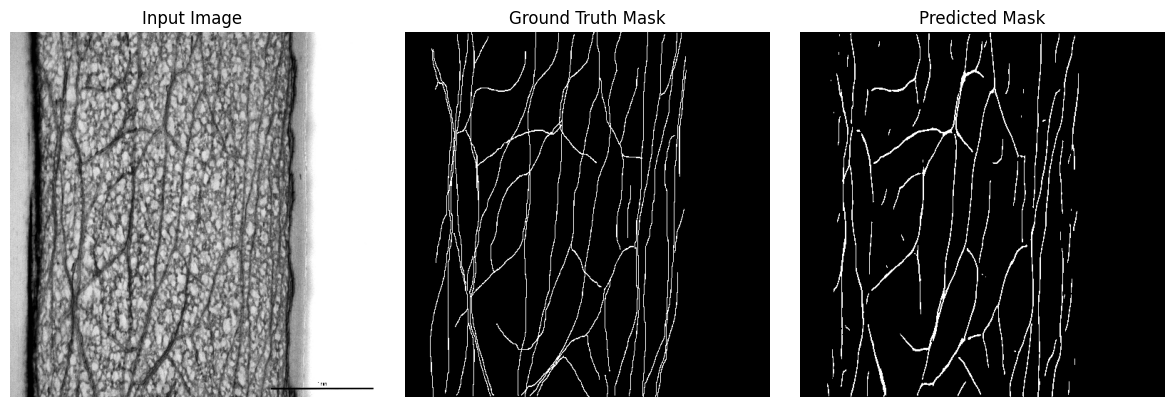

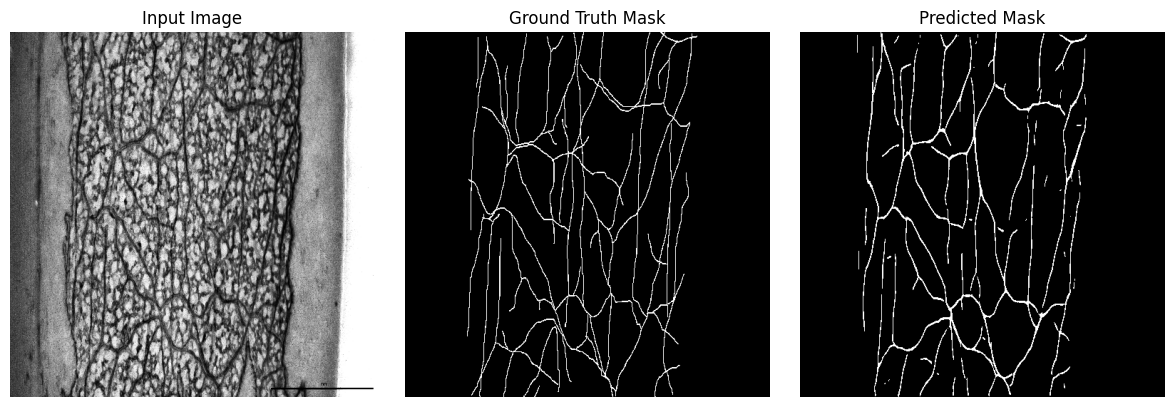

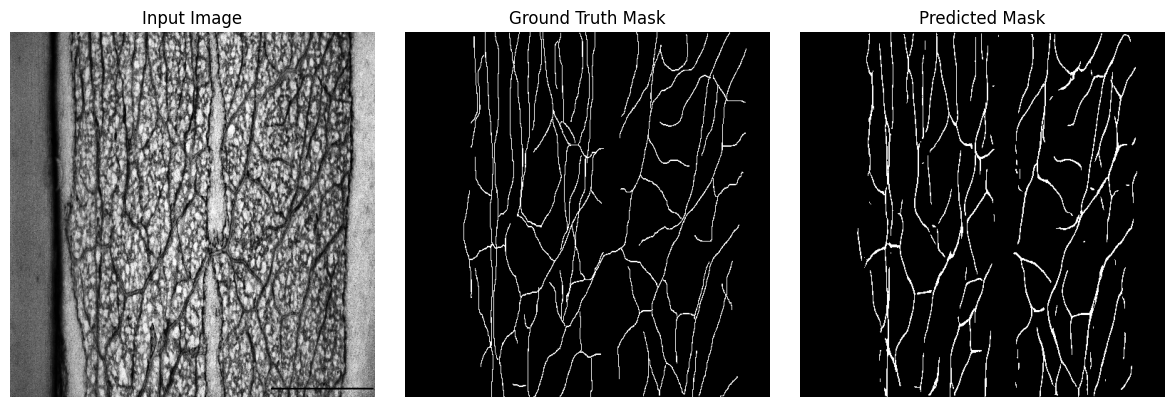

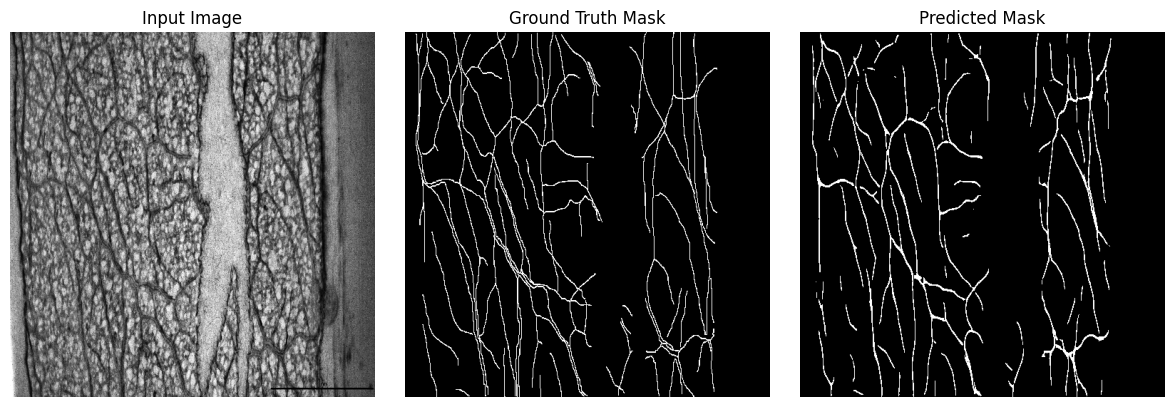

In [10]:
visualize_predictions(model, test_loader, num_samples=4)